In [ ]:
import sys
sys.path.append('..')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from fenics import *
from mshr import *
from scipy import signal
from src.utils.ou_process import ou_process_clip
from src.utils.get_position import generate_random_position

np.random.seed(0)

%matplotlib inline

In [98]:
class FurnaceEnvironment:
    def __init__(self,
                 num_cells: int,
                 dt: float,
                 epsilon: float,
                 domain_range: tuple,
                 linear_solver: str,
                 preconditioner: str,
                 action_min: float,
                 action_max: float,
                 state_pos: np.array,  # [I x 2] numpy integer array
                 action_pos: np.array):  # [J x 2] numpy integer array
        # Furnace Setting
        self.num_cells = num_cells
        self.dt = dt
        self.epsilon = epsilon
        self.domain_range = domain_range
        self.linear_solver = linear_solver
        self.preconditioner = preconditioner
        self.action_min = action_min
        self.action_max = action_max
        self.state_dim = state_pos.shape[0]
        self.action_dim = action_pos.shape[0]
        self.state_pos = state_pos
        self.action_pos = action_pos
        self.reset()

    def reset(self):
        self.domain = Rectangle(Point(self.domain_range[0], self.domain_range[0]),
                                Point(self.domain_range[1], self.domain_range[1]))
        self.mesh = generate_mesh(self.domain, self.num_cells)
        self.V = FunctionSpace(self.mesh, 'P', 1)

        self.bc = DirichletBC(self.V, Constant(0), DomainBoundary())

        # Define initial value
        self.u_0 = Constant(0)
        self.u_n = interpolate(self.u_0, self.V)

        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)

        self.u = Function(self.V)
        self.t = 0.0
        self.state_trajectory = []
        self.action_trajectory = []
        obs = self.observe()
        self.state_trajectory.append(obs)

    def observe(self):
        obs = []
        for pos in self.state_pos:
            obs.append(self.u(pos))
        obs = np.array(obs)
        return obs

    def generate_f(self, a):
        f_list = ['0.0']
        for k, pos in enumerate(self.action_pos):
            f_list.append('+{}*({}<=x[0] & x[0]<= {} & {}<=x[1] & x[1]<={})'.format(a[k],
                                                                                    pos[0] - self.epsilon,
                                                                                    pos[0] + self.epsilon,
                                                                                    pos[1] - self.epsilon,
                                                                                    pos[1] + self.epsilon))
        return ''.join(map(str, f_list))

    def step(self, action):
        self.f = Expression(self.generate_f(action), degree=2)
        self.u = TrialFunction(self.V)
        self.F = (self.u) * (self.v) * dx + (self.dt) * dot(grad(self.u), grad(self.v)) * dx - (
                    (self.u_n) + (self.dt) * (self.f)) * (self.v) * dx
        self.a, self.L = lhs(self.F), rhs(self.F)
        
        # self.A, self.b = assemble_system(self.a, self.L, self.bc)
        self.t += self.dt
        # self.u = Function(self.V)
        # solve(self.A, self.u.vector(), self.b, solver_parameters={'linear_solver': self.linear_solver, 'preconditioner': self.preconditioner})
        # solve(self.A, self.u, self.b, solver_parameters={'linear_solver': self.linear_solver, 'preconditioner': self.preconditioner})
        # solve(self.a==self.L, self.u.vector(), self.bc, solver_parameters={'linear_solver': self.linear_solver, 'preconditioner': self.preconditioner})
        # self.u_n.assign(self.u)
        
        
        
        self.A = assemble(self.a)
        self.b = assemble(self.L)
        self.bc.apply(self.A, self.b)
        self.u = Function(self.V)
        U = self.u.vector()
        solve(self.A, U, self.b)
        
        
        
        
        
        
        
        
        
        obs = self.observe()
        self.state_trajectory.append(obs)
        self.action_trajectory.append(action)
        return obs
    
    def return_trajectory(self):
        return np.stack(self.state_trajectory, axis=0), np.stack(self.action_trajectory, axis=0)

    def generate_random_trajectory(self, T):
        """
        :param T: int
        :return:
        """
        self.reset()
        action = np.zeros((T, self.action_dim))
        for k in range(self.action_dim):
            action[:, k] = ou_process_clip(len=T)
        action = action * (self.action_max - self.action_min) / 2 + (self.action_max - self.action_min) / 2
        for t in range(T):
            print('Now [{}] / [{}]'.format(t, T))
            self.step(action[t])
        state_trajectory, action_trajectory = self.return_trajectory()
        return state_trajectory, action_trajectory

In [107]:
num_cells = 20
dt = 0.05
epsilon = 0.2
domain_range = [-1.0, 1.0]
action_min = 0.0
action_max = 10.0
I = 1
J = 1
T = 5

state_pos, action_pos = generate_random_position(domain_range, I, J, epsilon)
state_pos = np.array([[0.5, 0.5]])
action_pos = np.array([[0.4, 0.4]])
action_list = np.random.uniform(action_min, action_max, (T, J))
# action_list = np.array([[4.0], [3.0], [5.0], [1.0], [3.0]])

In [108]:
linear_solver_list = ['bicgstab', 'cg', 'default', 'gmres', 'minres', 'mumps', 'petsc', 'richardson', 'superlu', 'superlu_dist', 'tfqmr', 'umfpack']
preconditioner_list = ['amg', 'default', 'hypre_amg', 'hypre_euclid', 'hypre_parasails', 'icc', 'ilu', 'jacobi', 'none', 'petsc_amg', 'sor']
# preconditioner_list = ['default', 'hypre_amg', 'hypre_euclid', 'hypre_parasalis', 'icc', 'ilu', 'jacobi', 'none', 'petsc_amg', 'sor']
linear_solver_list = ['default']
preconditioner_list = ['default']
for linear_solver in linear_solver_list:
    for preconditioner in preconditioner_list:
        state_list = []
        env = FurnaceEnvironment(num_cells, dt, epsilon, domain_range, linear_solver, preconditioner, action_min, action_max, state_pos, action_pos)
        start = time.time()
        for t in range(T):
            state = env.step(action_list[t])
            state_list.append(state)
        end = time.time()
        print('Linear solver: {}, Preconditioner: {}, Time: {}, Value: {}'.format(linear_solver, preconditioner, end-start, state_list[T-1][0]))

Linear solver: default, Preconditioner: default, Time: 8.971086025238037, Value: 0.029565579382889215


In [109]:
env2 = FurnaceEnvironment(num_cells, dt, epsilon, domain_range, linear_solver, preconditioner, action_min, action_max, state_pos, action_pos)
start = time.time()
for t in range(T):
    state = env2.step(action_list[t])
    state_list.append(state)
end = time.time()
print('Linear solver: {}, Preconditioner: {}, Time: {}, Value: {}'.format(linear_solver, preconditioner, end-start, state_list[T-1][0]))

Linear solver: default, Preconditioner: default, Time: 0.052785396575927734, Value: 0.029565579382889215


In [84]:
class FurnaceEnvironment:
    def __init__(self,
                 num_grid: int,
                 dt: float,
                 epsilon: float,
                 domain_range: [-1.0, 1.0],
                 action_min: float,
                 action_max: float,
                 state_pos: np.array,  # [I x 2] numpy integer array
                 action_pos: np.array):  # [J x 2] numpy integer array
        # Furnace Setting
        self.num_grid = num_grid
        self.dt = dt
        self.epsilon = epsilon
        self.domain_range = domain_range
        self.action_min = action_min
        self.action_max = action_max
        self.state_dim = state_pos.shape[0]
        self.action_dim = action_pos.shape[0]
        self.state_pos = state_pos
        self.action_pos = action_pos
        self.reset()

    def reset(self):
        self.domain = Rectangle(Point(self.domain_range[0], self.domain_range[0]),
                                Point(self.domain_range[1], self.domain_range[1]))
        self.mesh = generate_mesh(self.domain, self.num_grid)
        # self.V = FunctionSpace(self.mesh, 'CG', 1)
        self.V = FunctionSpace(self.mesh, 'P', 1)
        
        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)

        self.u_0 = Constant(0)
        self.u_n = interpolate(self.u_0, self.V)
        self.f = Constant(0)
        self.F = (self.u) * (self.v) * dx + (self.dt) * dot(grad(self.u), grad(self.v)) * dx - ((self.u_n) + (self.dt) * (self.f)) * (self.v) * dx
        self.a, self.L = lhs(self.F), rhs(self.F)

        self.bc = DirichletBC(self.V, Constant(0), DomainBoundary())
        self.A, self.b = assemble_system(self.a, self.L, self.bc)
    
        self.u = Function(self.V)
        self.t = 0.0
        self.state_trajectory = []
        self.action_trajectory = []
        self.observe()

    def observe(self):
        obs = []
        for pos in self.state_pos:
            obs.append(self.u(pos))
        obs = np.array(obs)
        self.state_trajectory.append(obs)
    
    def generate_f(self, a):
        f_list = ['0.0']
        for k, pos in enumerate(self.action_pos):
            f_list.append('+{}*({}<=x[0] & x[0]<= {} & {}<=x[1] & x[1]<={})'.format(a[k],
                                                                                    pos[0] - self.epsilon,
                                                                                    pos[0] + self.epsilon,
                                                                                    pos[1] - self.epsilon,
                                                                                    pos[1] + self.epsilon))
        return ''.join(map(str, f_list))
    
    def generate_source(self, a):
        f_0 = Expression('0.0', degree=0)
        for k, pos in enumerate(self.action_pos):
            f_0 = f_0 + Expression('({}<=x[0] & x[0]<= {} & {}<=x[1] & x[1]<={})? {} : 0.0'.format(pos[0] - self.epsilon,
                                                                                          pos[0] + self.epsilon,
                                                                                          pos[1] - self.epsilon,
                                                                                          pos[1] + self.epsilon,
                                                                                          a[k]), degree=2)
        # return ''.join(map(str, f_list))
        # return f_0

    def apply_action(self, action):
        for k, pos in enumerate(self.action_pos):
            delta = PointSource(self.V, Point(pos[0], pos[1]), action[k])
            delta.apply(self.b)
    
    
    def step(self, action):
        self.f = Expression(self.generate_f(action), degree=2)
        # self.f = self.generate_source(action)
        self.t += self.dt
        # self.apply_action(action)
        self.u = TrialFunction(self.V)
        
        self.F = (self.u) * (self.v) * dx + (self.dt) * dot(grad(self.u), grad(self.v)) * dx - ((self.u_n) + (self.dt) * (self.f)) * (self.v) * dx
        self.a, self.L = lhs(self.F), rhs(self.F)
        
        self.bc = DirichletBC(self.V, Constant(0), DomainBoundary())
        self.A, self.b = assemble_system(self.a, self.L, self.bc)
    
        self.u = Function(self.V)
        
        solve(self.A, self.u.vector(), self.b)
        # self.b.zero()
        # self.bc.apply(self.b)
        self.action_trajectory.append(action)
        self.observe()
        self.u_n.assign(self.u)
        # print(self.t)
        # c = plot(interpolate(self.u_n, self.V))
        # plt.colorbar(c)
        # plt.scatter(state_pos[:, 0], state_pos[:, 1], color='blue')
        # plt.scatter(action_pos[:, 0], action_pos[:, 1], color='red')
        # plt.show()
        
    def return_trajectory(self):
        return np.stack(self.state_trajectory, axis=0), np.stack(self.action_trajectory, axis=0)

    def generate_random_trajectory(self, T):
        """
        :param T: int
        :return:
        """
        self.reset()
        for t in range(T):
            action = np.random.uniform(self.action_min, self.action_max, (self.action_dim))
            # action = np.ones(self.action_dim) * 1
            self.step(action)
        state_trajectory, action_trajectory = self.return_trajectory()
        return state_trajectory, action_trajectory


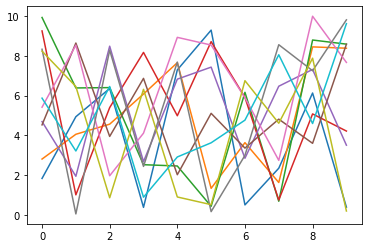

In [82]:
plt.plot(action_trajectory)
plt.show()

# Original Code

u is v_1
v is v_0
dx is dx(subdomain_id=everywhere)
dt is 0.1
grad is <function grad at 0x7f1635233ef0>
u_n is f_193
f is f_196
F is { v_0 * v_1 } * dx(<Mesh #179>[everywhere], {})
  +  { 0.1 * ((grad(v_1)) . (grad(v_0))) } * dx(<Mesh #179>[everywhere], {})
  +  { -1 * v_0 * (f_193 + 0.1 * f_196) } * dx(<Mesh #179>[everywhere], {})
a is { v_0 * v_1 } * dx(<Mesh #179>[everywhere], {})
  +  { 0.1 * (sum_{i_{16}} (grad(v_0))[i_{16}] * (grad(v_1))[i_{16}] ) } * dx(<Mesh #179>[everywhere], {})
L is { -1 * -1 * v_0 * (f_193 + 0.1 * f_196) } * dx(<Mesh #179>[everywhere], {})
bc is <dolfin.fem.dirichletbc.DirichletBC object at 0x7f1620075290>
u is f_197
Solving linear variational problem.
0.0016731730251372675
Solving linear variational problem.
0.005855292119409387


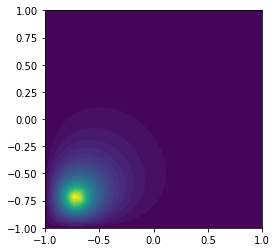

In [11]:
dt = 0.1
num_steps = 10

# Create mesh and define function space
# nx = ny = 50
# mesh = RectangleMesh(Point(-1, -1), Point(1, 1), nx, ny)

domain = Rectangle(Point(-1, -1), Point(1, 1))
mesh = generate_mesh(domain, 30)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Constant(0)
f = Expression('0.0+1000*(-0.77<=x[0] & x[0]<= -0.67 & -0.77<=x[1] & x[1]<=-0.67)', degree=2)

# f = interpolate(f, V)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
print('u is {}'.format(u))
print('v is {}'.format(v))
print('dx is {}'.format(dx))
print('dt is {}'.format(dt))
print('grad is {}'.format(grad))
print('u_n is {}'.format(u_n))
print('f is {}'.format(f))
print('F is {}'.format(F))
print('a is {}'.format(a))
print('L is {}'.format(L))
print('bc is {}'.format(bc))

# Time-stepping
u = Function(V)
t = 0
print('u is {}'.format(u))
t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))

t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))

In [12]:
print(u(0.5, 0.5))
u = TrialFunction(V)
f = Expression('0.0+1000*(-0.77<=x[0] & x[0]<= -0.67 & -0.77<=x[1] & x[1]<=-0.67)', degree=2)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)
u = Function(V)
t += dt
# Compute solution
solve(a == L, u, bc)
print(u(0.5, 0.5))

0.00671901725535928
Solving linear variational problem.
0.013424026306262151


# Environment Definition

In [2]:
class FurnaceEnvironment:
    def __init__(self,
                 num_grid: int,
                 dt: float,
                 domain_range: [-1.0, 1.0],
                 action_min: float,
                 action_max: float,
                 state_pos: np.array,  # [I x 2] numpy integer array
                 action_pos: np.array):  # [J x 2] numpy integer array
        # Furnace Setting
        self.num_grid = num_grid
        self.dt = dt
        self.domain_range = domain_range
        self.action_min = action_min
        self.action_max = action_max
        self.state_dim = state_pos.shape[0]
        self.action_dim = action_pos.shape[0]
        self.state_pos = state_pos
        self.action_pos = action_pos
        
        self.epsilon = 0.05
        self.reset()


        # f = Expression('0.0 + power * (x0 - epsilon <= x[0] & x[0] <= x0 + epsilon & x1 - epsilon <= x[1] & x[1] <= x1 + epsilon)', degree=2, power=power, x0=x0, x1=x1, epsilon=epsilon)
        # self.F = self.u*self.v*dx + self.dt*dot(grad(self.u), grad(self.v))*dx - (self.u_n + self.dt*self.f)*v*dx
        # a, L = lhs(F), rhs(F)

        # Create VTK file for saving solution
        

    def reset(self):
        self.domain = Rectangle(Point(self.domain_range[0], self.domain_range[0]), Point(self.domain_range[1], self.domain_range[1]))
        self.mesh = generate_mesh(self.domain, self.num_grid)
        self.V = FunctionSpace(self.mesh, 'P', 1)
        
        def boundary(x, on_boundary):
            return on_boundary
        self.bc = DirichletBC(self.V, Constant(0), boundary)

        # Define initial value
        self.u_0 = Constant(0)
        self.u_n = interpolate(self.u_0, self.V)
        
        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)
        
        self.u = Function(self.V)
        self.t = 0.0
        self.state_trajectory = []
        self.action_trajectory = []
        self.observe()
    
    
    def observe(self):
        obs = []
        for pos in self.state_pos:
            obs.append(self.u(pos))
        obs = np.array(obs)
        self.state_trajectory.append(obs)
    
    
    def generate_f(self, a):
        f_list = ['0.0']
        for k, pos in enumerate(action_pos):
            f_list.append('+{}*({}<=x[0] & x[0]<= {} & {}<=x[1] & x[1]<={})'.format(a[k],
                                                                                    pos[0] - self.epsilon,
                                                                                    pos[0] + self.epsilon,
                                                                                    pos[1] - self.epsilon,
                                                                                    pos[1] + self.epsilon))
        return ''.join(map(str, f_list))
    
    
    def step(self, action):
        # f = Expression(self.generate_f(action), degree=2)
        # u = TrialFunction(self.V)
        # u = self.u
        # v = self.v
        # dt = self.dt
        # u_n = self.u_n
        # bc = self.bc
        #  = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
        # a, L = lhs(F), rhs(F)
        # u = Function(self.V)
        # self.t += dt
        # solve(a == L, u, bc)
        # u_n.assign(u)
        # self.u = u
        # self.v = v
        # self.dt = dt
        # self.u_n = u_n
        # self.u = u
        
        self.f = Expression(self.generate_f(action), degree=2)
        self.u = TrialFunction(self.V)
        self.F = (self.u)*(self.v)*dx + (self.dt)*dot(grad(self.u), grad(self.v))*dx - ((self.u_n) + (self.dt)*(self.f))*(self.v)*dx
        self.a, self.L = lhs(self.F), rhs(self.F)
        self.t += self.dt
        self.u = Function(self.V)
        solve(self.a == self.L, self.u, self.bc)
        self.u_n.assign(self.u)
        print(action.shape)
        self.action_trajectory.append(action)
        self.observe()
    
    
    def return_trajectory(self):
        return np.stack(self.state_trajectory, axis=0), np.stack(self.action_trajectory, axis=0)
    
    
    def generate_random_trajectory(self, T):
        """
        :param T: int
        :return:
        """
        self.reset()
        for t in range(T):
            action = np.random.uniform(self.action_min, self.action_max, (self.action_dim))
            self.step(action)
        state_trajectory, action_trajectory = self.return_trajectory()
        return state_trajectory, action_trajectory

In [7]:
num_grid = 20
dt = 0.1
domain_range = [-1.0, 1.0]
action_min = 0.0
action_max = 1000.0
state_pos = np.array([[-0.5, -0.5],
                      [-0.5, 0.5],
                      [0.5, -0.5],
                      [0.5, 0.5]])
action_pos = np.array([[-0.7, -0.7],
                       [-0.7, 0.7],
                       [0.7, -0.7],
                       [0.7, 0.7]])
action_pos = np.array([[-0.7, -0.7],
                       [0.7, 0.7]])
print(state_pos.shape)
print(action_pos.shape)
T = 10

env = FurnaceEnvironment(num_grid=num_grid,
                         dt=dt,
                         domain_range=domain_range,
                         action_min=action_min,
                         action_max=action_max,
                         state_pos=state_pos,
                         action_pos=action_pos)

(4, 2)
(2, 2)


Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)
Solving linear variational problem.
(2,)


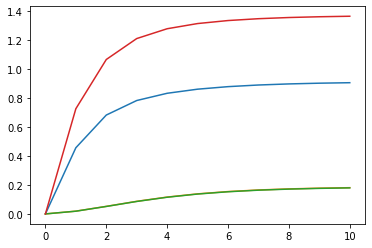

In [4]:
state_trajectory, action_trajectory = env.generate_random_trajectory(T)
plt.plot(state_trajectory)
plt.show()

In [5]:
print(state_trajectory.shape)
print(action_trajectory.shape)

(11, 4)
(10, 2)


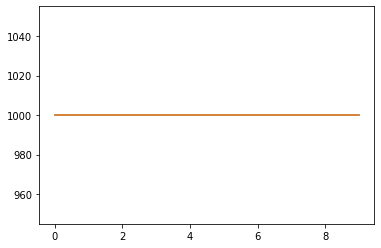

In [6]:
plt.plot(action_trajectory)
plt.show()

In [ ]:
dt = 0.1
num_steps = 10

# Create mesh and define function space
# nx = ny = 50
# mesh = RectangleMesh(Point(-1, -1), Point(1, 1), nx, ny)

domain = Rectangle(Point(-1, -1), Point(1, 1))
mesh = generate_mesh(domain, 20)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

epsilon = 0.003

x0 = 0.5222123123
x1 = 0.423213434324
power = 1000

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Constant(0)
f = Expression('0.0 + power * (x0 - epsilon <= x[0] & x[0] <= x0 + epsilon & x1 - epsilon <= x[1] & x[1] <= x1 + epsilon)', degree=2, power=power, x0=x0, x1=x1, epsilon=epsilon)
f = Expression('0.0+828.1073209848705*(-0.77<=x[0] & x[0]<= -0.6699999999999999 & -0.77<=x[1] & x[1]<=-0.6699999999999999)', degree=2)
# f = interpolate(f, V)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')

# Time-stepping
u = Function(V)

print('u is {}'.format(u))
print('v is {}'.format(v))
print('dx is {}'.format(dx))
print('dt is {}'.format(dt))
print('grad is {}'.format(grad))
print('u_n is {}'.format(u_n))
print('f is {}'.format(f))
print('F is {}'.format(F))
print('a is {}'.format(a))
print('L is {}'.format(L))
print('bc is {}'.format(bc))
t = 0
t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
vtkfile << (u, t)
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))

t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
vtkfile << (u, t)
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))

# My Version

v_1
v_0
dx(subdomain_id=everywhere)
0.1
<function grad at 0x7f8bbcdfdc20>
f_1558
f_1563
Solving linear variational problem.
0.001385566831390575
Solving linear variational problem.
0.004848810270587932


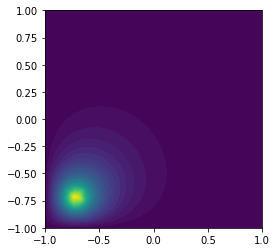

In [66]:
dt = 0.1
num_steps = 10

# Create mesh and define function space
# nx = ny = 50
# mesh = RectangleMesh(Point(-1, -1), Point(1, 1), nx, ny)

domain = Rectangle(Point(-1, -1), Point(1, 1))
mesh = generate_mesh(domain, 30)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

epsilon = 0.003

x0 = 0.5222123123
x1 = 0.423213434324
power = 1000
power_list = [1000, 2000]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Constant(0)
f = Expression('0.0 + power * (x0 - epsilon <= x[0] & x[0] <= x0 + epsilon & x1 - epsilon <= x[1] & x[1] <= x1 + epsilon)', degree=2, power=power, x0=x0, x1=x1, epsilon=epsilon)
f = Expression('0.0 + power_list * (x0 - epsilon <= x[0] & x[0] <= x0 + epsilon & x1 - epsilon <= x[1] & x[1] <= x1 + epsilon)', degree=2, power_list=power_list[0], x0=x0, x1=x1, epsilon=epsilon)
f = Expression('0.0+828.1073209848705*(-0.77<=x[0] & x[0]<= -0.6699999999999999 & -0.77<=x[1] & x[1]<=-0.6699999999999999)', degree=2)
# f = interpolate(f, V)
print(u)
print(v)
print(dx)
print(dt)
print(grad)
print(u_n)
print(f)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')

# Time-stepping
u = Function(V)
t = 0

t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
vtkfile << (u, t)
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))

t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
vtkfile << (u, t)
plot(u)
u_n.assign(u)
print(u(0.52, 0.53))


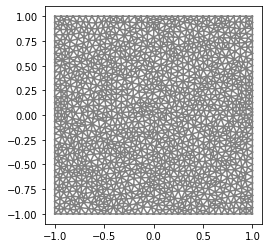

In [44]:
plot(mesh)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


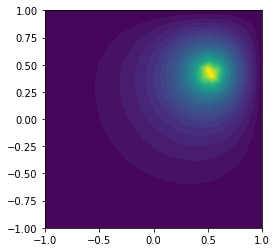

In [107]:
# num_steps = 20
list_u = []
for n in range(num_steps):
    # Update current time
    t += dt
    # Compute solution
    solve(a == L, u, bc)
    # Save to file and plot solution
    # vtkfile << (u, t)
    plot(u)
    # u_n.assign(u)
    list_u.append(u(0.52, 0.42))

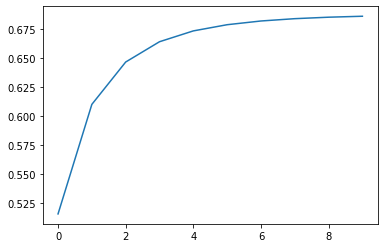

In [95]:
plt.plot(list_u)

In [96]:
u(0,0)

0.1114792081900693

Solving linear variational problem.


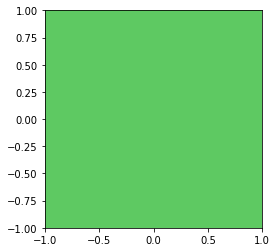

In [78]:
t += dt
# Compute solution
solve(a == L, u, bc)
# Save to file and plot solution
vtkfile << (u, t)
plot(u)
u_n.assign(u)

In [101]:
T = 2.0 # final time
num_steps = 50 # number of time steps
dt = T / num_steps # time step size

dt = 0.1
num_steps = 10

# Create mesh and define function space
# nx = ny = 50
# mesh = RectangleMesh(Point(-1, -1), Point(1, 1), nx, ny)

domain = Rectangle(Point(-1, -1), Point(1, 1))
mesh = generate_mesh(domain, 20)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

epsilon = 0.003

x0 = 0.5222123123
x1 = 0.423213434324
power = 1000


# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Constant(0)
f = Expression('0.0 + power * (x0 - epsilon <= x[0] & x[0] <= x0 + epsilon & x1 - epsilon <= x[1] & x[1] <= x1 + epsilon)', degree=2, power=power, x0=x0, x1=x1, epsilon=epsilon)
# f = interpolate(f, V)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')

# Time-stepping
u = Function(V)
t = 0

# Point Source

In [28]:
dt = 0.01
num_steps = 10

# Create mesh and define function space
# nx = ny = 50
# mesh = RectangleMesh(Point(-1, -1), Point(1, 1), nx, ny)

domain = Rectangle(Point(-1, -1), Point(1, 1))
mesh = generate_mesh(domain, 30)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(0)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
# f = Constant(0)

# f = interpolate(f, V)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)
t = 0

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


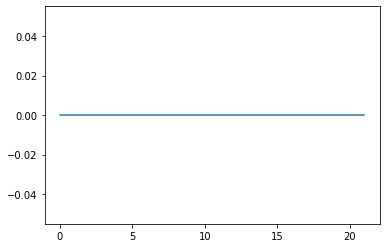

In [29]:
u = Function(V)
delta = PointSource(V, Point(0.2, 0.2), 100)
delta.apply(u.vector())
num_steps = 20
list_u = [0.0]
t += dt
solve(a== L, u, bc)
u_n.assign(u)
list_u.append(u(0.2, 0.2))
for _ in range(num_steps):
    t += dt
    solve(a== L, u, bc)
    u_n.assign(u)
    list_u.append(u(0.2, 0.2))
plt.plot(list_u)
plt.show()

In [12]:
class FurnaceEnvironment:
    def __init__(self,
                 num_grid: int,
                 dt: float,
                 domain_range: [-1.0, 1.0],
                 action_min: float,
                 action_max: float,
                 state_pos: np.array,  # [I x 2] numpy integer array
                 action_pos: np.array):  # [J x 2] numpy integer array
        # Furnace Setting
        self.num_grid = num_grid
        self.dt = dt
        self.domain_range = domain_range
        self.action_min = action_min
        self.action_max = action_max
        self.state_dim = state_pos.shape[0]
        self.action_dim = action_pos.shape[0]
        self.state_pos = state_pos
        self.action_pos = action_pos
        self.reset()

    def reset(self):
        self.domain = Rectangle(Point(self.domain_range[0], self.domain_range[0]),
                                Point(self.domain_range[1], self.domain_range[1]))
        self.mesh = generate_mesh(self.domain, self.num_grid)
        self.V = FunctionSpace(self.mesh, 'P', 1)

        def boundary(x, on_boundary):
            return on_boundary

        self.bc = DirichletBC(self.V, Constant(0), boundary)

        # Define initial value
        self.u_0 = Constant(0)
        self.u_n = interpolate(self.u_0, self.V)

        self.v = TestFunction(self.V)

        self.f = Constant(0)
        self.u = TrialFunction(self.V)
        self.F = (self.u) * (self.v) * dx + (self.dt) * dot(grad(self.u), grad(self.v)) * dx - (
                    (self.u_n) + (self.dt) * (self.f)) * (self.v) * dx
        self.a, self.L = lhs(self.F), rhs(self.F)
        self.A, self.b = assemble_system(self.a, self.L, self.bc)
        self.u = Function(self.V)
        self.t = 0.0
        self.state_trajectory = []
        self.action_trajectory = []
        self.observe()

    def observe(self):
        obs = []
        for pos in self.state_pos:
            obs.append(self.u(pos))
        obs = np.array(obs)
        self.state_trajectory.append(obs)

    def apply_action(self, action):
        for k, pos in enumerate(self.action_pos):
            delta = PointSource(self.V, Point(pos[0], pos[1]), action[k])
            delta.apply(self.f)

    def step(self, action):
        self.t += self.dt
        self.apply_action(action)
        solve(self.A, self.u.vector(), self.b)
        self.u_n.assign(self.u)
        self.b.zero()
        # self.bc.apply(self.b)
        self.action_trajectory.append(action)
        self.observe()

    def return_trajectory(self):
        return np.stack(self.state_trajectory, axis=0), np.stack(self.action_trajectory, axis=0)

    def generate_random_trajectory(self, T):
        """
        :param T: int
        :return:
        """
        self.reset()
        for t in range(T):
            action = np.random.uniform(self.action_min, self.action_max, (self.action_dim))
            self.step(action)
        state_trajectory, action_trajectory = self.return_trajectory()
        return state_trajectory, action_trajectory


In [24]:
state_pos, action_pos = generate_random_position(domain_range, I, J, epsilon)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


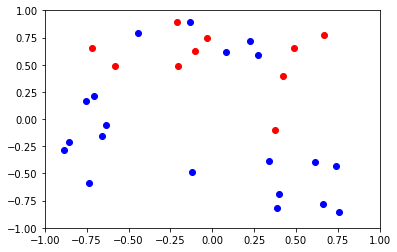

In [33]:
num_grid = 10
dt = 1
epsilon = 0.1
domain_range = [-1.0, 1.0]
action_min = 0.0
action_max = 1.0
I = 20
J = 10

env = FurnaceEnvironment(num_grid, dt, domain_range, action_min, action_max, state_pos, action_pos)
T = 100
state_trajectory, action_trajectory = env.generate_random_trajectory(T)
plt.scatter(state_pos[:, 0], state_pos[:, 1], color='blue')
plt.scatter(action_pos[:, 0], action_pos[:, 1], color='red')
plt.xlim(domain_range)
plt.ylim(domain_range)
plt.show()

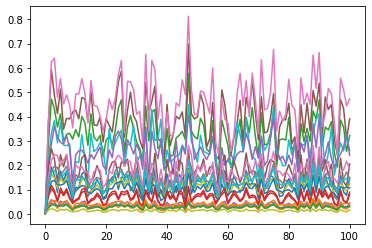

In [34]:
plt.plot(state_trajectory)

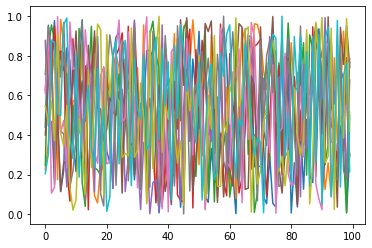

In [35]:
plt.plot(action_trajectory)

In [53]:
state_pos

array([[-0.05390988, -0.53149314],
       [ 0.84666519, -0.0935377 ],
       [-0.55976084,  0.00644853],
       [-0.52222538,  0.31372293],
       [-0.03196889, -0.63049194],
       [ 0.07156681, -0.75933319],
       [ 0.48010989, -0.55057222],
       [-0.01525402,  0.55779233],
       [ 0.04058992,  0.75545134],
       [-0.88026813,  0.3685194 ],
       [ 0.29351941,  0.16354811],
       [-0.61145786,  0.55553178],
       [-0.3378518 ,  0.40236958],
       [-0.11676027,  0.78278077],
       [ 0.23807025,  0.26842308],
       [-0.58897334, -0.00716173],
       [ 0.76118649,  0.79541017],
       [-0.09956667, -0.18654369],
       [ 0.00300768,  0.43849318],
       [-0.1541334 , -0.07363381]])

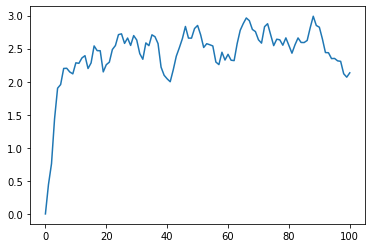

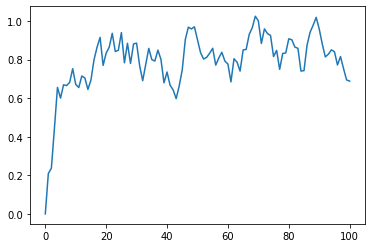

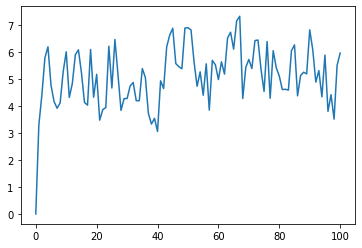

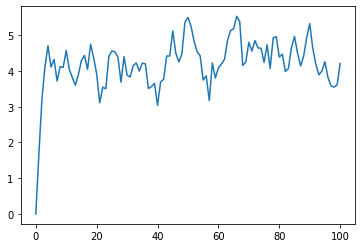

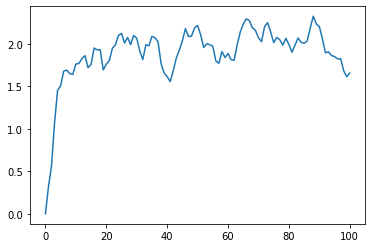

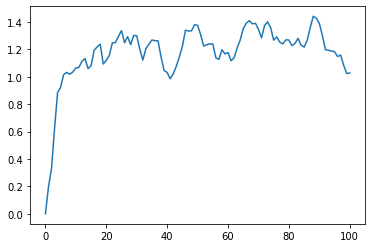

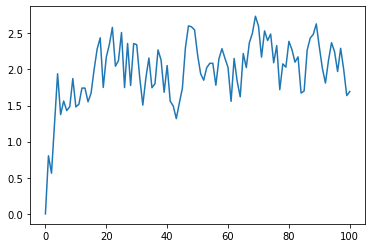

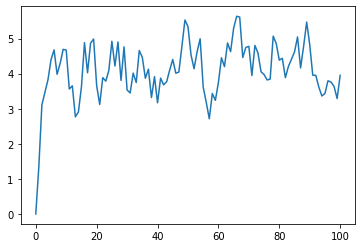

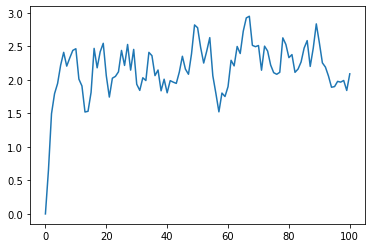

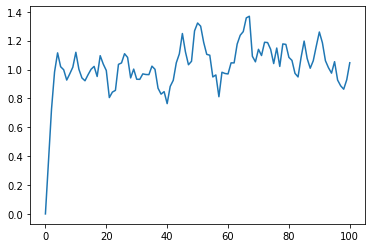

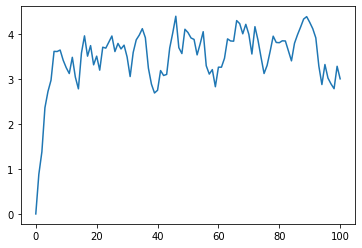

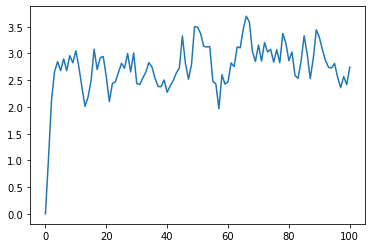

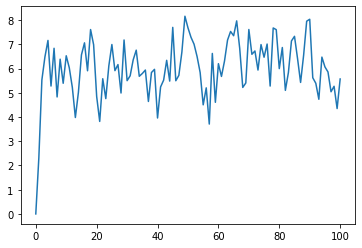

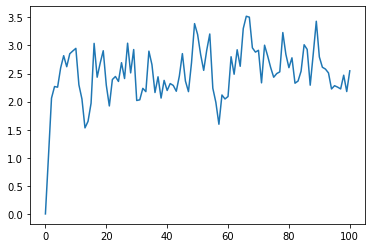

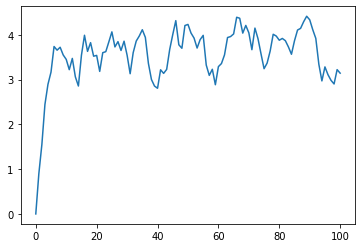

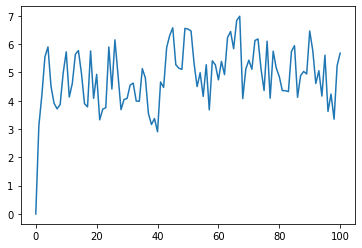

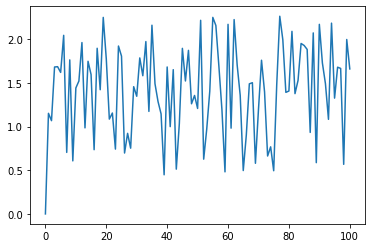

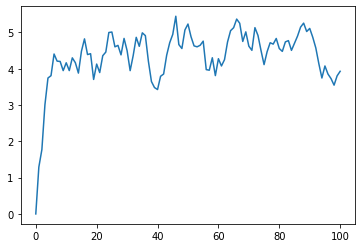

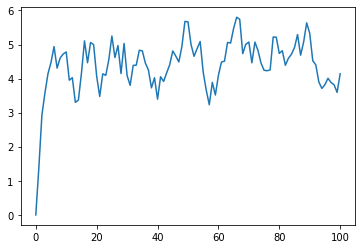

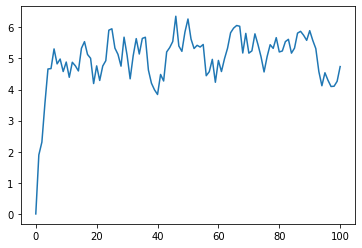

In [54]:
for i in range(I):
    plt.plot(state_trajectory[:, i])
    plt.show()

In [18]:
class FurnaceEnvironment:
    def __init__(self,
                 num_grid: int,
                 dt: float,
                 epsilon: float,
                 domain_range: [-1.0, 1.0],
                 action_min: float,
                 action_max: float,
                 state_pos: np.array,  # [I x 2] numpy integer array
                 action_pos: np.array):  # [J x 2] numpy integer array
        # Furnace Setting
        self.num_grid = num_grid
        self.dt = dt
        self.epsilon = epsilon
        self.domain_range = domain_range
        self.action_min = action_min
        self.action_max = action_max
        self.state_dim = state_pos.shape[0]
        self.action_dim = action_pos.shape[0]
        self.state_pos = state_pos
        self.action_pos = action_pos
        self.reset()

    def reset(self):
        self.domain = Rectangle(Point(self.domain_range[0], self.domain_range[0]),
                                Point(self.domain_range[1], self.domain_range[1]))
        self.mesh = generate_mesh(self.domain, self.num_grid)
        self.V = FunctionSpace(self.mesh, 'P', 1)

        def boundary(x, on_boundary):
            return on_boundary

        self.bc = DirichletBC(self.V, Constant(0), boundary)

        # Define initial value
        self.u_0 = Constant(0)
        self.u_n = interpolate(self.u_0, self.V)

        self.u = TrialFunction(self.V)
        self.v = TestFunction(self.V)

        self.u = Function(self.V)
        self.t = 0.0
        self.state_trajectory = []
        self.action_trajectory = []
        self.observe()

    def observe(self):
        obs = []
        for pos in self.state_pos:
            obs.append(self.u(pos))
        obs = np.array(obs)
        self.state_trajectory.append(obs)

    def generate_f(self, a):
        f_list = ['0.0']
        for k, pos in enumerate(self.action_pos):
            f_list.append('+{}*({}<=x[0] & x[0]<= {} & {}<=x[1] & x[1]<={})'.format(a[k],
                                                                                    pos[0] - self.epsilon,
                                                                                    pos[0] + self.epsilon,
                                                                                    pos[1] - self.epsilon,
                                                                                    pos[1] + self.epsilon))
        return ''.join(map(str, f_list))

    def step(self, action):
        self.f = Expression(self.generate_f(action), degree=2)
        self.u = TrialFunction(self.V)
        self.F = (self.u) * (self.v) * dx + (self.dt) * dot(grad(self.u), grad(self.v)) * dx - (
                    (self.u_n) + (self.dt) * (self.f)) * (self.v) * dx
        self.a, self.L = lhs(self.F), rhs(self.F)
        # self.A, self.b = assemble_system(self.a, self.L, self.bc)
        self.t += self.dt
        self.u = Function(self.V)
        # solve(self.A, self.u.vector(), self.b)
        solve(self.a == self.L, self.u, self.bc)
        self.u_n.assign(self.u)
        self.action_trajectory.append(action)
        self.observe()

    def return_trajectory(self):
        return np.stack(self.state_trajectory, axis=0), np.stack(self.action_trajectory, axis=0)

    def generate_random_trajectory(self, T):
        """
        :param T: int
        :return:
        """
        self.reset()
        for t in range(T):
            action = np.random.uniform(self.action_min, self.action_max, (self.action_dim))
            action = np.ones(self.action_dim) * (t+1)
            self.step(action)
        state_trajectory, action_trajectory = self.return_trajectory()
        return state_trajectory, action_trajectory


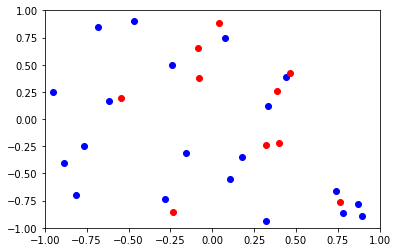

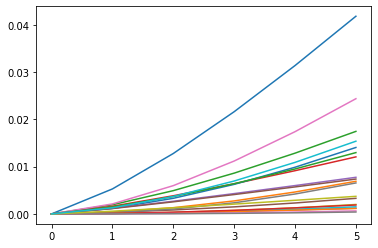

In [17]:
num_grid = 10
dt = 0.05
epsilon = 0.05
domain_range = [-1.0, 1.0]
action_min = 0.0
action_max = 100.0
I = 20
J = 10
state_pos, action_pos = generate_random_position(domain_range, I, J, epsilon)
env = FurnaceEnvironment(num_grid, dt, epsilon, domain_range, action_min, action_max, state_pos, action_pos)
T = 5
state_trajectory, action_trajectory = env.generate_random_trajectory(T)
plt.scatter(state_pos[:, 0], state_pos[:, 1], color='blue')
plt.scatter(action_pos[:, 0], action_pos[:, 1], color='red')
plt.xlim(domain_range)
plt.ylim(domain_range)
plt.show()
plt.plot(state_trajectory)
plt.show()

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


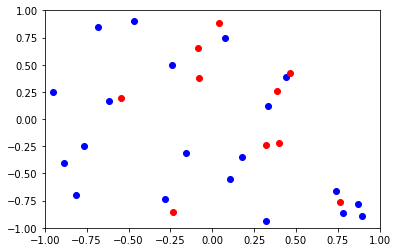

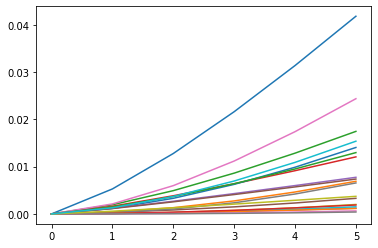

In [19]:
num_grid = 10
dt = 0.05
epsilon = 0.05
domain_range = [-1.0, 1.0]
action_min = 0.0
action_max = 100.0
I = 20
J = 10
# state_pos, action_pos = generate_random_position(domain_range, I, J, epsilon)
env = FurnaceEnvironment(num_grid, dt, epsilon, domain_range, action_min, action_max, state_pos, action_pos)
T = 5
state_trajectory, action_trajectory = env.generate_random_trajectory(T)
plt.scatter(state_pos[:, 0], state_pos[:, 1], color='blue')
plt.scatter(action_pos[:, 0], action_pos[:, 1], color='red')
plt.xlim(domain_range)
plt.ylim(domain_range)
plt.show()
plt.plot(state_trajectory)
plt.show()